In [152]:
import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from omegaconf import OmegaConf
from app.data import BYUCustomDataset
from app.utils import get_data

In [2]:
OmegaConf.register_new_resolver("eval", resolver=eval, replace=True)

In [3]:
cfg = OmegaConf.load("../src/app/config/config.yaml")

In [4]:
train_df, val_df = get_data(cfg, mode="fit")

In [5]:
dataset = BYUCustomDataset(cfg, df=train_df, mode="train")

In [295]:
data = dataset.get_data_dict(idx=300)

In [298]:
torch.where(data["target"] == 1)

(tensor([134]), tensor([407]), tensor([356]))

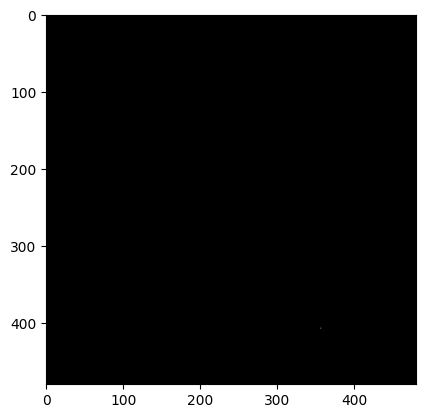

In [ ]:
plt.imshow(data["input"][134], cmap="gray")
plt.imshow(data["zyx"][134], cmap="gray")
plt.show()

In [48]:
[dim / 3 for dim in data["target"].shape]

[96.0, 160.0, 160.0]

In [49]:
ds = F.adaptive_max_pool3d(data["target"].unsqueeze(0).to(torch.float), (96, 160, 160))

In [50]:
data["target"].max()

tensor(1, dtype=torch.uint8)

In [51]:
ds.max()

tensor(1.)

In [63]:
138 / 3

46.0

In [76]:
(118 + (1 / 3)) / (1 / 3)

355.0

In [55]:
torch.where(ds == 1.0)

(tensor([0]), tensor([44]), tensor([135]), tensor([118]))

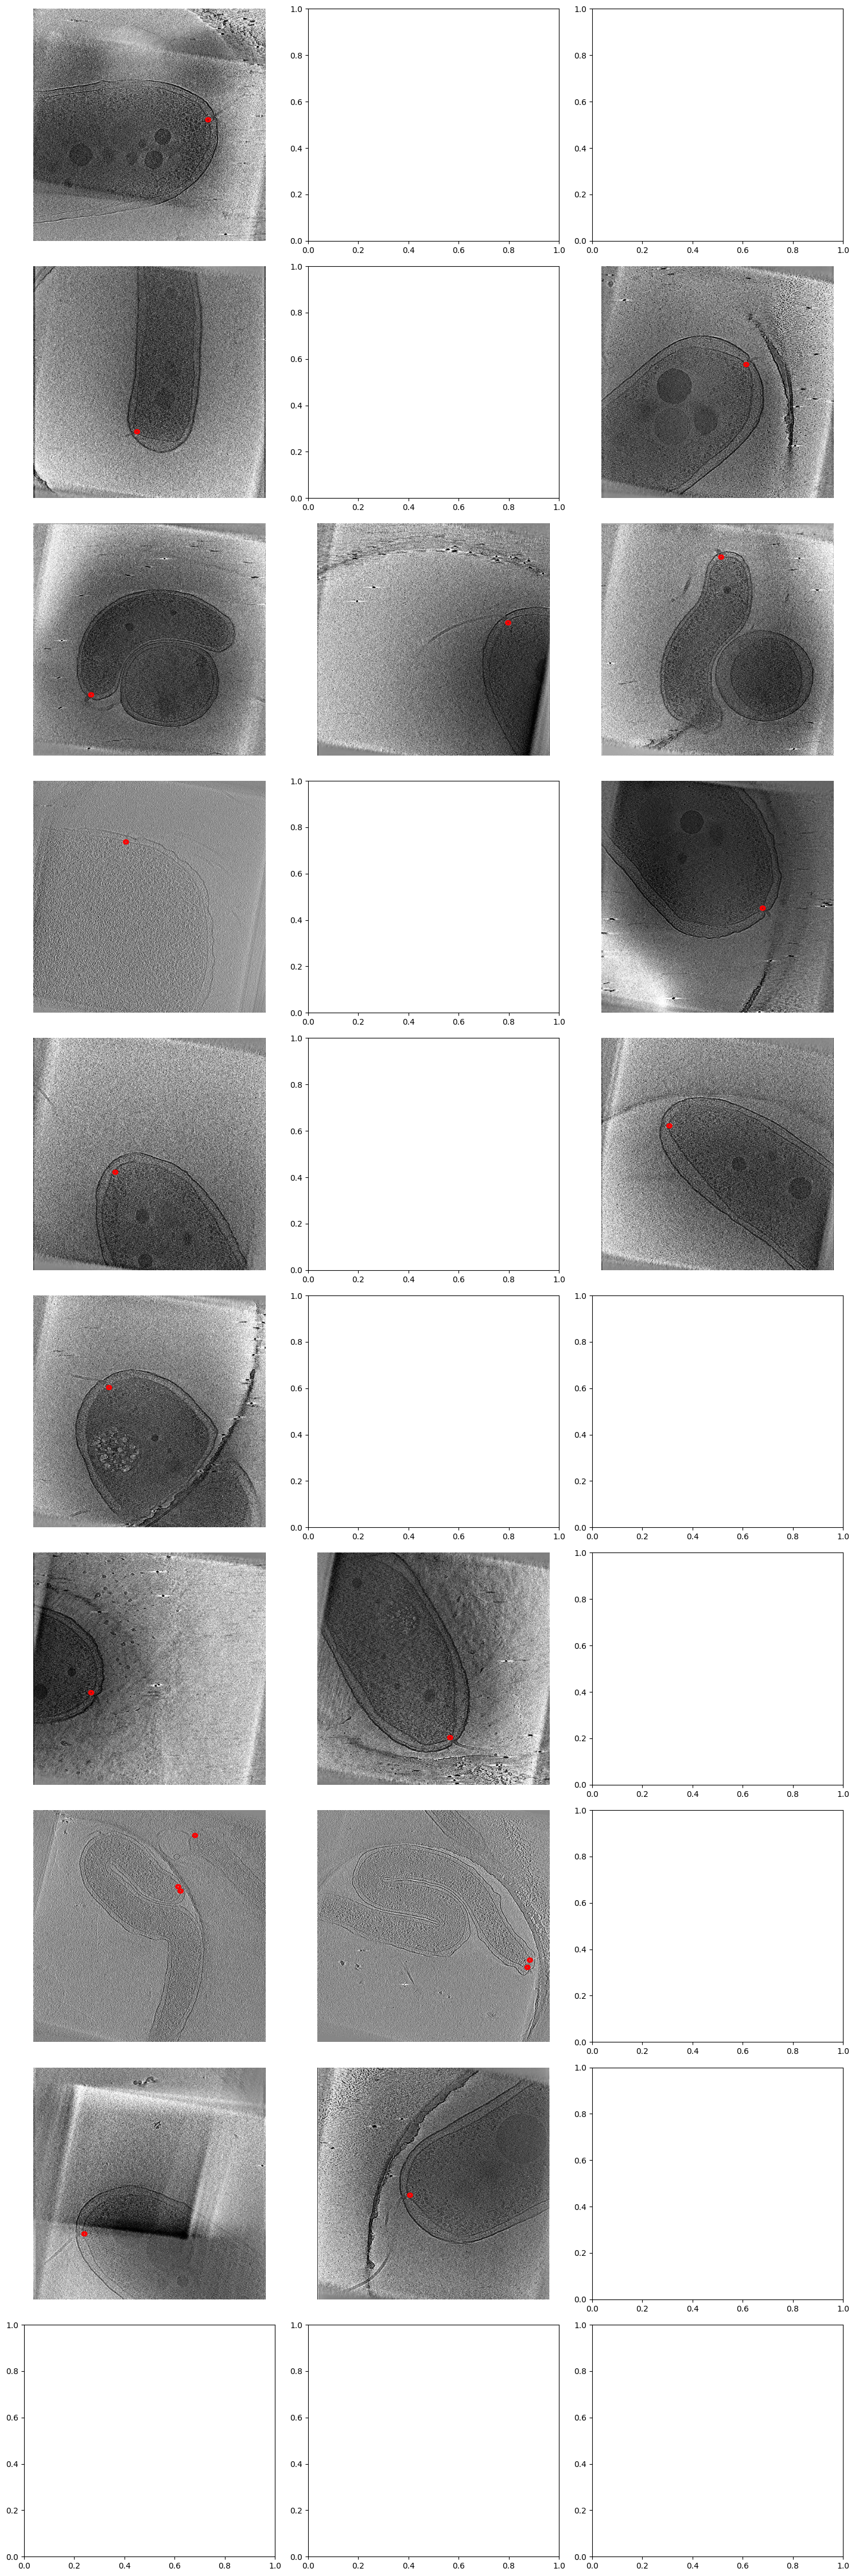

In [77]:
DISPLAY_RANGE = [112, 142]
fig, axs = plt.subplots(10, 3, figsize=(15, 45))
for i in range(30):
    data = dataset.get_data_dict(idx=DISPLAY_RANGE[0] + i)
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    z = data["zyx"][0][0]
    if z == -1:
        continue
    ax.imshow(data["input"][int(z)], cmap="gray")
    for z, y, x, id_, vxs in data["zyx"]:
        ax.scatter(
            x + 2, y, color="red", s=20, linewidth=2, marker="o", facecolors="none"
        )
        ax.scatter(
            x, y, color="red", s=20, linewidth=2, marker="o", facecolors="none"
        )  # s=10 pour la taille des points
    ax.axis("off")
plt.tight_layout()
plt.show()

In [142]:
x_pooled_cords = []
y_pooled_cords = []
z_pooled_cords = []
x_computed_cords = []
y_computed_cords = []
z_computed_cords = []
true_cords = []
ids = []

for i in range(len(dataset)):
    data = dataset.get_data_dict(idx=i)
    if data["zyx"][0][0] == -1:
        continue
    dim = data["dim"]
    s = data["input"].shape
    zyx = torch.from_numpy(
        train_df.sort_values(by=["z", "y", "x"])
        .loc[train_df["id"] == data["id"], ["z", "y", "x"]]
        .values
    )
    true_cords.append(zyx[0])
    mask = torch.zeros(dim)
    mask[
        zyx[:, 0].to(torch.int),
        zyx[:, 1].to(torch.int),
        zyx[:, 2].to(torch.int),
    ] = 1.0
    pooled_cords = torch.where(
        F.adaptive_max_pool3d(mask.unsqueeze(0).to(torch.float), (s[0], s[1], s[2]))
        == 1.0
    )
    computed_cords = torch.where(data["target"] == 1.0)
    z_pooled_cords.append(pooled_cords[1][0])
    y_pooled_cords.append(pooled_cords[2][0])
    x_pooled_cords.append(pooled_cords[3][0])
    z_computed_cords.append(computed_cords[0][0])
    y_computed_cords.append(computed_cords[1][0])
    x_computed_cords.append(computed_cords[2][0])
    ids.append(data["id"])

In [167]:
zyxs = torch.cat([t.reshape(1, -1) for t in true_cords], dim=0)

In [169]:
delta_analysis_df = pd.DataFrame(
    dict(
        z=zyxs[:, 0],
        y=zyxs[:, 1],
        x=zyxs[:, 2],
        z_pooled=torch.tensor(z_pooled_cords).numpy(),
        y_pooled=torch.tensor(y_pooled_cords).numpy(),
        x_pooled=torch.tensor(x_pooled_cords).numpy(),
        z_computed=torch.tensor(z_computed_cords).numpy(),
        y_computed=torch.tensor(y_computed_cords).numpy(),
        x_computed=torch.tensor(x_computed_cords).numpy(),
        id=ids,
    )
)

In [171]:
data["scale"]

tensor([0.3600, 0.5172, 0.5000])

In [172]:
scales = []
ids = []

for i in range(len(dataset)):
    data = dataset.get_data_dict(idx=i)
    if data["zyx"][0][0] == -1:
        continue
    scales.append(data["scale"])
    ids.append(data["id"])

In [182]:
scales = torch.cat([s.reshape(1, -1) for s in scales], dim=0)

In [188]:
delta_analysis_df = delta_analysis_df.merge(
    pd.DataFrame(
        dict(z_scale=scales[:, 0], y_scale=scales[:, 1], x_scale=scales[:, 2], id=ids)
    ),
    how="inner",
    on="id",
)

In [ ]:
# delta_analysis_df.to_csv("delta_analysis.csv", index=False)

In [208]:
delta_analysis_df["z_pool_err"] = delta_analysis_df["z"] - (
    delta_analysis_df["z_pooled"] / delta_analysis_df["z_scale"]
)
delta_analysis_df["z_comp_err"] = delta_analysis_df["z"] - (
    delta_analysis_df["z_computed"] / delta_analysis_df["z_scale"]
)
delta_analysis_df["y_pool_err"] = delta_analysis_df["y"] - (
    delta_analysis_df["y_pooled"] / delta_analysis_df["y_scale"]
)
delta_analysis_df["y_comp_err"] = delta_analysis_df["y"] - (
    delta_analysis_df["y_computed"] / delta_analysis_df["y_scale"]
)
delta_analysis_df["x_pool_err"] = delta_analysis_df["x"] - (
    delta_analysis_df["x_pooled"] / delta_analysis_df["x_scale"]
)
delta_analysis_df["x_comp_err"] = delta_analysis_df["x"] - (
    delta_analysis_df["x_computed"] / delta_analysis_df["x_scale"]
)

In [210]:
delta_analysis_df.describe()

z           y           x    z_pooled    y_pooled    x_pooled  \
count  331.000000  331.000000  331.000000  331.000000  331.000000  331.000000   
mean   147.966767  488.398792  481.377644  130.253776  245.990937  247.410876   
std     62.608902  197.123307  207.911912   47.581340   99.392106  106.648902   
min      0.000000   59.000000   30.000000    0.000000   30.000000   15.000000   
25%    109.500000  348.500000  326.000000  102.000000  174.500000  167.500000   
50%    146.000000  492.000000  491.000000  132.000000  249.000000  249.000000   
75%    177.000000  625.500000  646.000000  157.000000  314.000000  331.500000   
max    432.000000  904.000000  896.000000  256.000000  467.000000  463.000000   

       z_computed  y_computed  x_computed          id     z_scale     y_scale  \
count  331.000000  331.000000  331.000000  331.000000  331.000000  331.000000   
mean   131.205438  246.691843  248.362538  313.072508    0.910115    0.504787   
std     47.596856   99.369994  106.656749  183.334173    0.129298    0.007875   
min      0.000000   31.000000   16.000000    1.000000    0.576000    0.500000   
25%    103.000000  175.500000  168.500000  157.000000    0.960000    0.500000   
50%    133.000000  250.000000  250.000000  308.000000    0.960000    0.500000   
75%    158.000000  314.000000  332.500000  464.000000    0.960000    0.517241   
max    257.000000  468.000000  464.000000  646.000000    0.960000    0.519481   

          x_scale  z_pool_err  z_comp_err  y_pool_err  y_comp_err  x_pool_err  \
count  331.000000  331.000000  331.000000  331.000000  331.000000  331.000000   
mean     0.515139    0.530543   -0.550986    0.657812   -0.726315    0.916702   
std      0.005389    0.353085    0.344415    0.559730    0.594879    0.566347   
min      0.500000   -0.000004   -1.638899   -0.000027   -1.908336   -0.000025   
25%      0.517241    0.249997   -0.791670    0.000000   -1.000013    0.466642   
50%      0.517241    0.541661   -0.541669    0.799989   -1.000000    0.866659   
75%      0.517241    0.749998   -0.291670    1.000000    0.000000    1.387495   
max      0.517241    1.722218    0.000000    1.889558    0.000000    1.916685   

       x_comp_err  
count  331.000000  
mean    -0.929068  
std      0.568230  
min     -1.933320  
25%     -1.400021  
50%     -0.933358  
75%     -0.400032  
max      0.000000

In [216]:
delta_analysis_df["z_scale"].unique()

array([0.96 , 0.576], dtype=float32)

In [218]:
train_df.axis0.unique()

array([500, 300, 600, 800, 494])

In [220]:
delta_analysis_df["y_scale"].unique()

array([0.50052136, 0.5194805 , 0.5       , 0.51724136], dtype=float32)

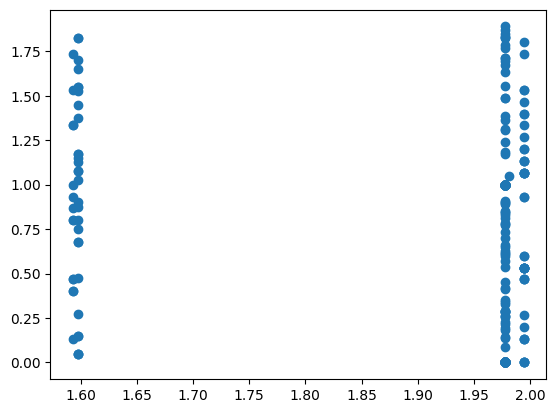

In [221]:
plt.scatter(
    delta_analysis_df["y_scale"]
    + delta_analysis_df["z_scale"]
    + delta_analysis_df["x_scale"],
    delta_analysis_df["y_pool_err"],
)

In [227]:
train_df["volumes"] = train_df.axis0 * train_df.axis1 * train_df.axis2

In [228]:
delta_analysis_df = delta_analysis_df.merge(
    train_df[["id", "volumes"]], how="inner", on="id"
)

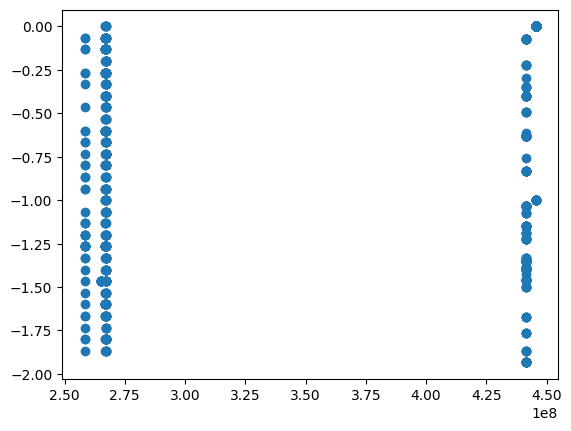

In [231]:
plt.scatter(delta_analysis_df["volumes"], delta_analysis_df["x_comp_err"])

In [276]:
m = torch.zeros((7, 7, 7))
m[:] = 1.0

In [279]:
m[1:-1, 1:-1, 1:-1] = 0.0
m[3, 3, 3] = 1.0

In [289]:
m_int = (
    F.interpolate(m.unsqueeze(0).unsqueeze(0), (3, 3, 3), mode="nearest")
    .squeeze(0)
    .squeeze(0)
)